# Finetuning Segment Anything with `µsam`

This notebook shows how to use Segment Anything for Microscopy to fine-tune a Segment Anything Model (SAM) on your custom data.

This notebook has been modified based on the notebook provided along with the micro-sam software (https://github.com/computational-cell-analytics/micro-sam)
https://github.com/computational-cell-analytics/micro-sam/blob/master/notebooks/sam_finetuning.ipynb

### Load required dependencies

In [81]:
import os
from glob import glob
from IPython.display import FileLink

import tifffile
import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components
from skimage import measure, morphology, segmentation
from skimage.measure import regionprops, label
import torch
import math
import gc
from contextlib import nullcontext
import pandas as pd
import math
from roifile import ImagejRoi, roiwrite
from scipy import ndimage
import re
import torch_em
from torch_em.model import UNETR
from torch_em.util.debug import check_loader
from torch_em.loss import DiceBasedDistanceLoss
from torch_em.util.util import get_random_colors
from torch_em.transform.label import PerObjectDistanceTransform

from micro_sam import util
import micro_sam.training as sam_training
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.instance_segmentation import (
    InstanceSegmentationWithDecoder,
    get_predictor_and_decoder,
    mask_data_to_segmentation
)

### Required functions

In [ ]:
class LabelTransform:
    def __init__(self, train_instance_segmentation):
        self.train_instance_segmentation = train_instance_segmentation
        
    def __call__(self, labels):
        if self.train_instance_segmentation:
            # Computes the distance transform for objects to jointly perform the additional decoder-based automatic instance segmentation (AIS) and finetune Segment Anything.
            label_transform = PerObjectDistanceTransform(
                distances=True,
                boundary_distances=True,
                directed_distances=False,
                foreground=True,
                instances=True,
                min_size=25
            )
        else:
            # Ensures the individual object instances.to finetune the clasiscal Segment Anything.
            label_transform = torch_em.transform.label.connected_components

        labels = label_transform(labels)
        return labels

class CudaMemoryManager:
    def __enter__(self):
        torch.cuda.empty_cache()
        gc.collect()

    def __exit__(self, exc_type, exc_val, exc_tb):
        torch.cuda.empty_cache()
        gc.collect()

#Function for the AIS
def run_automatic_instance_segmentation(image, checkpoint_path, model_type="vit_b_lm", device=None):
    """Automatic Instance Segmentation by training an additional instance decoder in SAM.

    NOTE: It is supported only for `µsam` models.
    
    Args:
        image: The input image.
        model_type: The choice of the `µsam` model.
        
    Returns:
        The instance segmentation.
    """
    # Step 1: Initialize the model attributes using the finetuned µsam model weights.
    #   - the 'predictor' object for generating predictions using the Segment Anything model.
    #   - the 'decoder' backbone (for AIS).
    predictor, decoder = get_predictor_and_decoder(
        model_type=model_type,  # choice of the Segment Anything model
        checkpoint_path=checkpoint_path,  # overwrite to pass our own finetuned model
        device=device,  # the device to run the model inference
    )
    
    # Step 2: Computation of the image embeddings from the vision transformer-based image encoder.
    image_embeddings = util.precompute_image_embeddings(
        predictor=predictor,  # the predictor object responsible for generating predictions
        input_=image,  # the input image
        ndim=2,  # number of input dimensions
    )
    
    # Step 3: Combining the decoder with the Segment Anything backbone for automatic instance segmentation.
    ais = InstanceSegmentationWithDecoder(predictor, decoder)
    
    # Step 4: Initializing the precomputed image embeddings to perform faster automatic instance segmentation.
    ais.initialize(
        image=image,  # the input image
        image_embeddings=image_embeddings,  # precomputed image embeddings
    )

    # Step 5: Getting automatic instance segmentations for the given image and applying the relevant post-processing steps.
    prediction = ais.generate()
    prediction = mask_data_to_segmentation(prediction, with_background=True)
    
    return prediction

### Let's locate the dataset

In [55]:
#Folder with traiing data
DATA_FOLDER = '/home/matlabuser/Documents/SAM/training_new'

# Select folders for training
train_dir = '/home/matlabuser/Documents/SAM/new_training_data'
segmentation_dir = '/home/matlabuser/Documents/SAM/new_labels'

# Select separate folder for validation data
val_dir = '/home/matlabuser/Documents/SAM/new_val_data'
val_segmentation_dir = '/home/matlabuser/Documents/SAM/new_val_labels'


### Let's create the dataloaders

#### First, let's visualize how our images look.

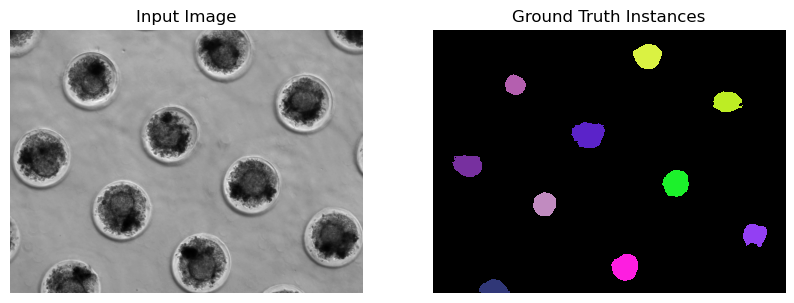

In [56]:
image_paths = sorted(glob(os.path.join(train_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    segmentation = connected_components(segmentation)
    ax[1].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")
    
    plt.show()
    plt.close()
    
    break  # comment this out in case you want to visualize all the images

#### Next, let's create the dataloaders

In [57]:
# torch_em.default_segmentation_loader is a convenience function to build a torch dataloader
# from image data and labels for training segmentation models.
# It supports image data in various formats. Here, we load image data and labels from the two
# folders with tif images that were downloaded by the example data functionality, by specifying
# `raw_key` and `label_key` as `*.tif`. This means all images in the respective folders that end with
# .tif will be loadded.
# The function supports many other file formats. For example, if you have tif stacks with multiple slices
# instead of multiple tif images in a foldder, then you can pass raw_key=label_key=None.
# For more information, here is the documentation: https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/README.md

# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Alternative: if you have tif stacks you can just set raw_key and label_key to None
# raw_key, label_key= None, None

# The 'roi' argument can be used to subselect parts of the data.
# Here, we use it to select the first 70 images (frames) for the train split and the other frames for the val split.

#We just load all images for training an validation from different folders
train_roi = np.s_[:, :, :]
val_roi = np.s_[:, :, :]

#### Label Transform

The idea here is to convert the ground-truth to the desired instance for finetuning Segment Anything, and in addition if desired, to learn the foreground and distances to the object centers and object boundaries.

In [59]:
# The script below returns the train or val data loader for finetuning SAM.

# The data loader must be a torch data loader that returns `x, y` tensors,
# where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive

# Here, we use `torch_em.default_segmentation_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb
batch_size = 1  # the training batch size
patch_shape = (1, 1024, 1024)  # the size of patches for training

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
train_instance_segmentation = True

label_transform = LabelTransform(train_instance_segmentation)

train_loader = torch_em.default_segmentation_loader(
    raw_paths=train_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    patch_shape=patch_shape,
    batch_size=batch_size,
    ndim=2,
    is_seg_dataset=True,
    rois=train_roi,
    label_transform=label_transform,
    shuffle=True,
    raw_transform=sam_training.identity,
)
val_loader = torch_em.default_segmentation_loader(
    raw_paths=val_dir,
    raw_key=raw_key,
    label_paths=val_segmentation_dir,
    label_key=label_key,
    patch_shape=patch_shape,
    batch_size=batch_size,
    ndim=2,
    is_seg_dataset=True,
    rois=val_roi,
    label_transform=label_transform,
    shuffle=True,
    raw_transform=sam_training.identity,
)

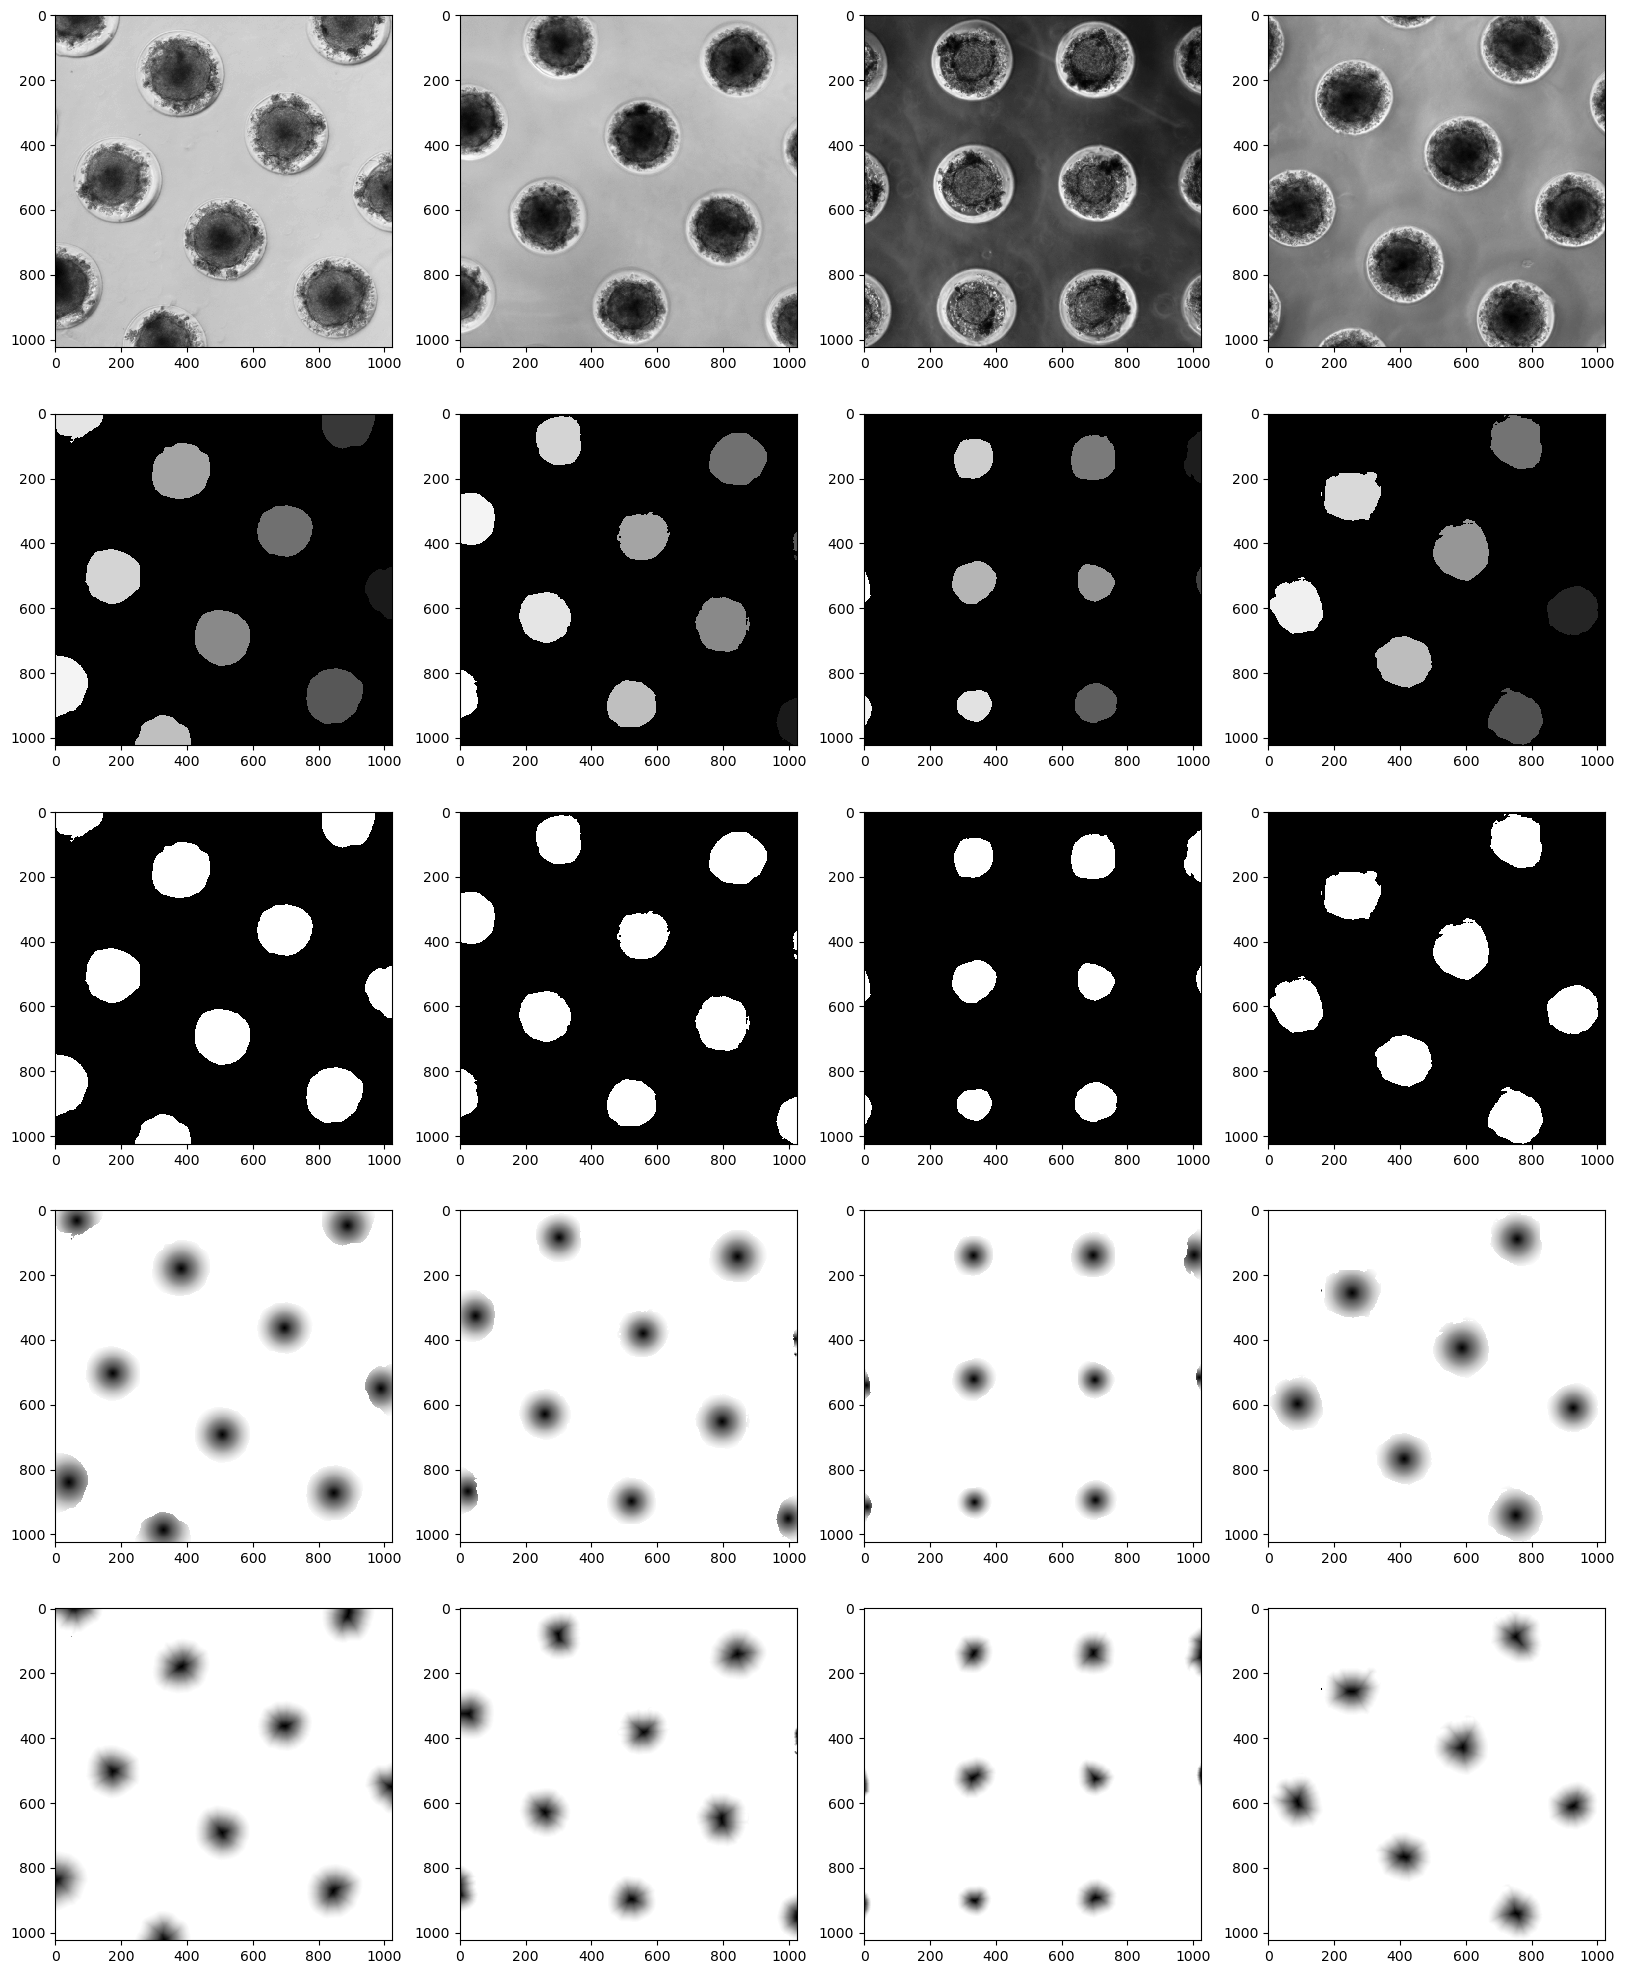

In [60]:
# Let's check how our samples look from the dataloader
check_loader(train_loader, 4, plt=True)
check_loader(val_loader, 4, plt=True)

### Run the actual model finetuning

In [ ]:
# All hyperparameters for training.
n_objects_per_batch = 5  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 100  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_l"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam_spheroidv2"


# Run training
sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(root_dir, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

**NOTE**: The user needs to decide whether to finetune the Segment Anything model, or the `µsam`'s "finetuned microscopy models" for their dataset. Here, we finetune on the Segment Anything model for simplicity. For example, if you choose to finetune the model from the light microscopy generalist models, you need to update the `model_type` to `vit_b_lm` and it takes care of initializing the model with the desired weights)

### Train networks on subset of data

In [ ]:
modelnames = ['CS1-2', 'CS2A', 'CS2B', 'CS5']
n_train_images = 12  # Number of training images per model
n_val_images = 12    # Number of validation images per model

for i, modelname in enumerate(modelnames):
    if i == 0:
        continue
    
    with CudaMemoryManager():
        train_start = i * n_train_images
        train_end = train_start + n_train_images
        val_start = i * n_val_images
        val_end = val_start + n_val_images
        train_roi = (slice(train_start, train_end), slice(None), slice(None))
        val_roi = (slice(val_start, val_end), slice(None), slice(None))
        
        train_loader = torch_em.default_segmentation_loader(
            raw_paths=train_dir,
            raw_key=raw_key,
            label_paths=segmentation_dir,
            label_key=label_key,
            patch_shape=patch_shape,
            batch_size=batch_size,
            ndim=2,
            is_seg_dataset=True,
            rois=train_roi,
            label_transform=label_transform,
            shuffle=True,
            raw_transform=sam_training.identity,
        )
        
        val_loader = torch_em.default_segmentation_loader(
            raw_paths=val_dir,
            raw_key=raw_key,
            label_paths=val_segmentation_dir,
            label_key=label_key,
            patch_shape=patch_shape,
            batch_size=batch_size,
            ndim=2,
            is_seg_dataset=True,
            rois=val_roi,
            label_transform=label_transform,
            shuffle=True,
            raw_transform=sam_training.identity,
        )
        
        checkpoint_name = f'sam_spheroidv2_{modelname}'
        
        sam_training.train_sam(
            name=checkpoint_name,
            save_root=os.path.join(root_dir, "models"),
            model_type=model_type,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs,
            n_objects_per_batch=n_objects_per_batch,
            with_segmentation_decoder=train_instance_segmentation,
            device=device,
        )
    
    # Explicitly delete objects
    del train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()

### Export all models

In [ ]:
base_checkpoint_name = 'sam_spheroidv2'
#base_checkpoint_name = 'sam_spheroidv2_vit_l_lm'

#modelnames = ['','CS1-2', 'CS2A', 'CS2B', 'CS5']
modelnames = ['', 'CS2A', 'CS2B', 'CS5']

best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")
save_path = os.path.join("models", "export","sam_spheroidv2_vit_l_lm.zip")
train_instance_segmentation = True  # Set this to True or False based on your setup
model_type = "vit_l_lm"

for model_name in modelnames:
    if model_name == '':
        checkpoint_name = base_checkpoint_name
    else:
        checkpoint_name = f"{base_checkpoint_name}_{model_name}"
    best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")
    save_path = os.path.join("models", "export",f"{base_checkpoint_name}_{model_name}.zip")
    util.export_custom_sam_model(best_checkpoint,model_type,save_path)


### Run automatic instance segmentation (AIS) prediction on folders

In [ ]:
def get_image_paths(folder_path):
    return [
        f for f in glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)
        if 'mask' not in os.path.basename(f) and 'labelIm' not in os.path.basename(f) and '_with_overlay' not in os.path.basename(f)

        
    ]
def merge_overlapping_labels(label_image):
    # Check if the image is 2D or 3D
    if label_image.ndim == 2:
        selem = morphology.disk(1)
    elif label_image.ndim == 3:
        selem = morphology.ball(1)
    else:
        raise ValueError("Unsupported image dimension. Expected 2D or 3D image.")

    # Dilate each label to find overlaps
    dilated = morphology.dilation(label_image, selem)
    
    # Find overlapping regions
    overlap = (dilated > 0) & (label_image == 0)
    
    # Assign overlapping regions to the nearest label
    overlap_labels = segmentation.watershed(image=np.zeros_like(label_image), 
                                            markers=label_image, 
                                            mask=dilated > 0)
    
    # Relabel the image
    return label(overlap_labels)

def filter_small_labels(label_image, min_size=100):
    return morphology.remove_small_objects(label_image, min_size=min_size)

def create_outline_roi(label_region):
    # Find contours of the region
    contours = measure.find_contours(label_region.image, 0.5)
    
    if contours:
        # Use the first contour (usually the outer boundary)
        contour = contours[0]
        
        # Add the offset to the contour coordinates
        contour[:, 0] += label_region.bbox[0]
        contour[:, 1] += label_region.bbox[1]
        
        # Swap x and y coordinates to match ImageJ's expectation
        contour = contour[:, [1, 0]]
        
        # Create an outline ROI
        roi = ImagejRoi.frompoints(contour.astype(np.float32))
        roi.name = f"Label_{label_region.label}"
        
        return roi
    
    return None

def analyze_label_image(label_image):
    props = regionprops(label_image)
    measurements = []
    rois = []
    for prop in props:
        area = prop.area
        perimeter = prop.perimeter
        height = prop.bbox[2] - prop.bbox[0]
        width = prop.bbox[3] - prop.bbox[1]
        diameter = prop.equivalent_diameter
        volume = (4/3) * math.pi * (diameter/2)**3  # Assuming spherical shape
        circular_area = math.pi*((height+width)/4)**2
        circular_volume = (4/3) * math.pi*((height+width)/4)**3 

        measurements.append({
            'Label': prop.label,
            'Area': area,
            'Height': height,
            'Width': width,
            'Perimeter': perimeter,
            'Diameter': diameter,
            'Volume': volume,
            'Circular_Area': circular_area,
            'Cicular_Volume': circular_volume
        })

        # Create ROI for ImageJ
        roi = create_outline_roi(prop)
        if roi:
            rois.append(roi)

    return pd.DataFrame(measurements), rois

# Main script and input parameters

#input_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/PDX Paris/"
#input_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/Primary_TNBC/TNBC2/"
#input_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/Resistant/"
input_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/Sensitive/"

device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
base_checkpoint_name = 'sam_spheroidv2'
best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")
train_instance_segmentation = True  # Set this to True or False based on your setup
model_type = "vit_l"
modelnames = ['','CS1-2', 'CS2A', 'CS2B', 'CS5']
#modelnames = ['CS1-2', 'CS2A', 'CS2B', 'CS5']

image_paths = get_image_paths(input_folder)
print(f"Found {len(image_paths)} images.")

for model_name in modelnames:
    if model_name == '':
        checkpoint_name = base_checkpoint_name
    else:
        checkpoint_name = f"{base_checkpoint_name}_{model_name}"
    best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")
    print(best_checkpoint)
    assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
    for i, image_path in enumerate(image_paths):
        print(f"\nProcessing image {i+1}/{len(image_paths)}:")
        print(f"File: {image_path}")
        
        try:
            # Read the TIFF file
            image = tifffile.imread(image_path)
            
            print(f"Image shape: {image.shape}")
            print(f"Image dtype: {image.dtype}")
            
            # Run automatic instance segmentation
            prediction = run_automatic_instance_segmentation(
                image=image,
                checkpoint_path=best_checkpoint,
                model_type=model_type,
                device=device
            )
            
            # Ensure prediction is a label image
            if prediction.dtype != np.int32:
                prediction = label(prediction > 0)
            
            # Merge overlapping labels and filter small objects
            try:
                merged_prediction = merge_overlapping_labels(prediction)
                filtered_prediction = filter_small_labels(merged_prediction, min_size=100)
            except Exception as e:
                print(f"Warning: Error in merging or filtering. Using original prediction. Error: {str(e)}")
                filtered_prediction = prediction
            
            # Visualize the predictions
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image, cmap="gray")
            ax[0].axis("off")
            ax[0].set_title("Input Image")
            ax[1].imshow(prediction, cmap='nipy_spectral', interpolation="nearest")
            ax[1].axis("off")
            ax[1].set_title("Original Predictions")
            ax[2].imshow(filtered_prediction, cmap='nipy_spectral', interpolation="nearest")
            ax[2].axis("off")
            ax[2].set_title("Merged and Filtered Predictions")
            plt.show()
            plt.close()
            
            # Save the filtered prediction with "labelIm_" prefix
            output_filename = f"labelIm_{model_name}_{os.path.basename(image_path)}"
            output_path = os.path.join(os.path.dirname(image_path), output_filename)
            
            # Ensure the label image is saved as 16-bit unsigned integer
            filtered_prediction_16bit = filtered_prediction.astype(np.uint16)
            tifffile.imwrite(output_path, filtered_prediction_16bit, compression='zlib')
            print(f"Saved: {output_path}")
    
            # Analyze label image
            measurements_df, rois = analyze_label_image(filtered_prediction)
    
            # Save measurements
            measurements_path = os.path.join(os.path.dirname(image_path), f"measurements_{model_name}_{os.path.basename(image_path)}.csv")
            measurements_df.to_csv(measurements_path, index=False)
            print(f"Saved measurements: {measurements_path}")
    
            # Save ROIs
            roi_path = os.path.join(os.path.dirname(image_path), f"ROIs_{model_name}_{os.path.basename(image_path)}.zip")
            roiwrite(roi_path, rois)
            print(f"Saved ROIs: {roi_path}")
            
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")

print("Done processing images.")

### Make plots for all models

In [80]:
def read_scaling_info(tumor_folder):
    """
    Read the scaling.csv file from the tumor folder.
    Returns a DataFrame with scaling information or None if file is not found.
    """
    scaling_file = os.path.join(tumor_folder, 'scaling.csv')
    if os.path.exists(scaling_file):
        try:
            scaling_df = pd.read_csv(scaling_file)
            print(f"Found scaling information for {os.path.basename(tumor_folder)}")
            return scaling_df
        except Exception as e:
            print(f"Error reading scaling file: {e}")
            return None
    else:
        print(f"No scaling.csv found in {tumor_folder}. Using default pixel size of 1.")
        return None

def apply_scaling(data, scaling_df):
    """
    Apply pixel size scaling to relevant measurements.
    """
    if scaling_df is None:
        return data
    
    scaled_data = data.copy()
    
    # List of measurements that need scaling
    # Linear measurements (multiply by pixel size)
    linear_measures = ['Height', 'Width', 'Perimeter', 'Diameter']
    # Area measurements (multiply by pixel size squared)
    area_measures = ['Area', 'Circular_Area']
    # Volume measurements (multiply by pixel size cubed)
    volume_measures = ['Volume', 'Circular_Volume']
    
    # Merge scaling information with data
    scaled_data = scaled_data.merge(
        scaling_df[['day', 'treatment', 'pixelsize']], 
        left_on=['Day', 'Treatment'], 
        right_on=['day', 'treatment'],
        how='left'
    )
    
    # Fill any missing scaling values with 1
    scaled_data['pixelsize'].fillna(1, inplace=True)
    
    # Apply scaling to each type of measurement
    for measure in linear_measures:
        if measure in scaled_data.columns:
            scaled_data[measure] = scaled_data[measure] * scaled_data['pixelsize']
    
    for measure in area_measures:
        if measure in scaled_data.columns:
            scaled_data[measure] = scaled_data[measure] * (scaled_data['pixelsize'] ** 2)
    
    for measure in volume_measures:
        if measure in scaled_data.columns:
            scaled_data[measure] = scaled_data[measure] * (scaled_data['pixelsize'] ** 3)
    
    # Clean up merged columns
    scaled_data.drop(['day', 'treatment', 'pixelsize'], axis=1, inplace=True)
    
    return scaled_data

def update_plot_labels(measure):
    """
    Return the appropriate unit label based on the measure type.
    """
    linear_measures = ['Height', 'Width', 'Perimeter', 'Diameter']
    area_measures = ['Area', 'Circular_Area']
    volume_measures = ['Volume', 'Circular_Volume']
    
    base_name = measure.replace('Normalized_', '')
    
    if base_name in linear_measures:
        return f"{measure} (µm)"
    elif base_name in area_measures:
        return f"{measure} (µm²)"
    elif base_name in volume_measures:
        return f"{measure} (µm³)"
    else:
        return measure

# Modify the create_combined_plots function to include units in labels
def create_combined_plots(data, output_folder, tumor_model, normalized=False):
    measurements = ['Area', 'Height', 'Width', 'Perimeter', 'Diameter', 'Volume', 'Circular_Area', 'Circular_Volume']
    if normalized:
        measurements = [f'Normalized_{m}' for m in measurements]
    days = sorted(data['Day'].unique())
    treatments = sorted(data['Treatment'].unique())
    ai_models = sorted(data['AI_Model'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(ai_models)))

    for measure in measurements:
        plt.figure(figsize=(20, 10))
        
        positions = np.arange(len(treatments) * len(days))
        width = 0.8 / len(ai_models)
        
        for i, ai_model in enumerate(ai_models):
            model_data = data[data['AI_Model'] == ai_model]
            
            boxplot_positions = []
            boxplot_data = []
            
            for day in days:
                for treatment in treatments:
                    day_treatment_data = model_data[(model_data['Day'] == day) & (model_data['Treatment'] == treatment)]
                    if not day_treatment_data.empty:
                        pos = positions[len(treatments) * days.index(day) + treatments.index(treatment)]
                        boxplot_positions.append(pos + i*width - 0.4 + width/2)
                        boxplot_data.append(day_treatment_data[measure])
            
            bp = plt.boxplot(boxplot_data,
                           positions=boxplot_positions,
                           widths=width, patch_artist=True,
                           boxprops=dict(facecolor=colors[i], alpha=0.6),
                           medianprops=dict(color='black'),
                           showfliers=False)
            
            for j, (day, treatment) in enumerate([(d, t) for d in days for t in treatments]):
                day_treatment_data = model_data[(model_data['Day'] == day) & (model_data['Treatment'] == treatment)]
                if not day_treatment_data.empty:
                    pos = positions[j]
                    plt.scatter(np.random.normal(pos + i*width - 0.4 + width/2, 0.01, len(day_treatment_data)),
                              day_treatment_data[measure], 
                              c=[colors[i]], s=20, alpha=0.6)

        plt.xlabel('Day and Treatment')
        plt.ylabel(update_plot_labels(measure))
        plt.title(f'{"Normalized " if normalized else ""}Distribution of {measure} by AI Model, Day, and Treatment - {tumor_model}')
        plt.xticks(positions, [f'D{day} T{treatment}' for day in days for treatment in treatments], rotation=45)
        
        handles = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='none', alpha=0.6) for i in range(len(ai_models))]
        plt.legend(handles, ai_models, loc='upper right')

        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'{"normalized_" if normalized else ""}{measure}_combined_{tumor_model}.png'), dpi=300, bbox_inches='tight')
        plt.close()

#### Main execution

In [ ]:
base_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/Resistant/"
tumor_models = ["CR1", "CR4A", "CR4B", "CR5"]
#tumor_models = ["CS1-2", "CS2A", "CS2B", "CS5"]
ai_models = ["", "CS1-2", "CS2A", "CS2B", "CS5"]  # "" represents the model trained on all data

for tumor_model in tumor_models:
    print(f"Processing tumor model: {tumor_model}")
    
    tumor_folder = os.path.join(base_folder, tumor_model)
    if not os.path.exists(tumor_folder):
        print(f"Folder for {tumor_model} not found. Skipping...")
        continue
    
    # Read scaling information
    scaling_df = read_scaling_info(tumor_folder)
    
    # Read all CSV files for this tumor model
    data = read_csv_files(tumor_folder, ai_models)
    
    if data.empty:
        print(f"No data found for {tumor_model}. Skipping...")
        continue
    
    # Apply scaling to the data
    data = apply_scaling(data, scaling_df)
    
    # Create output folder within the tumor model folder
    output_folder = os.path.join(tumor_folder, "analysis_results")
    os.makedirs(output_folder, exist_ok=True)
    
    # Create combined plots for this tumor model
    create_combined_plots(data, output_folder, tumor_model)
    create_individual_ai_model_plots(data, output_folder, tumor_model)
    
    # Normalize data
    normalized_data = normalize_to_day0_median(data)
    
    # Create normalized combined plots for this tumor model
    create_combined_plots(normalized_data, output_folder, tumor_model, normalized=True)
    create_individual_ai_model_plots(normalized_data, output_folder, tumor_model, normalized=True)
    
    # Create the reorganized Excel file
    create_reorganized_excel(normalized_data, output_folder, tumor_model)
    
    # Save data to Excel files
    for ai_model in ai_models:
        model_data = normalized_data[normalized_data['AI_Model'] == (ai_model if ai_model else "alldata")]
        save_to_excel(model_data, output_folder, tumor_model, ai_model if ai_model else "alldata")
    
    print(f"Finished processing {tumor_model}")

print("All tumor models have been processed. Plots and Excel files are saved in their respective 'analysis_results' folders.")

### Comparison with manual measurements

In [ ]:
def extract_image_id(filename):
    match = re.search(r'(\d+)\.tif\.csv$', filename)
    if match:
        return int(match.group(1))
    else:
        print(f"Warning: Could not extract image ID from filename: {filename}")
        return None

def read_csv_files(folder_path, ai_models):
    data = []
    for ai_model in ai_models:
        for day_treatment_folder in sorted(glob(os.path.join(folder_path, 'd*'))):
            day, treatment = os.path.basename(day_treatment_folder).split()
            day = int(day[1:])
            treatment = int(treatment)
            
            csv_files = glob(os.path.join(day_treatment_folder, f'measurements_{ai_model}_*.csv'))
            for file in csv_files:
                df = pd.read_csv(file)
                df['AI_Model'] = ai_model if ai_model else "alldata"
                df['Day'] = day
                df['Treatment'] = treatment
                if 'Circular_Area' not in df.columns:
                    df['Circular_Area'] = math.pi*((df['Height']+df['Width'])/4)**2
                if 'Circular_Volume' not in df.columns:
                    df['Circular_Volume'] = (4/3) * math.pi * ((df['Height']+df['Width'])/4)**3 
                image_id = extract_image_id(os.path.basename(file))
                if image_id is not None:
                    df['Image'] = image_id
                    data.append(df)
                else:
                    print(f"Skipping file due to invalid image ID: {file}")
    
    return pd.concat(data, ignore_index=True) if data else pd.DataFrame()

def read_manual_measurements(file_path):
    manual_df = pd.read_csv(file_path, sep=",")
    manual_df = manual_df.dropna(subset=['Vcore'])  # Remove rows with NaN Vcore
    return manual_df

def average_measurements(df, group_cols, value_cols):
    return df.groupby(group_cols)[value_cols].mean().reset_index()

def create_scatter_plots(manual_df, ai_df, output_folder, tumor_model):
    ai_models = ai_df['AI_Model'].unique()
    
    manual_avg = average_measurements(manual_df, ['Day', 'Treatment', 'Image'], 'Vcore')
    
    for ai_model in ai_models:
        model_df = ai_df[ai_df['AI_Model'] == ai_model]
        
        ai_avg = average_measurements(model_df, ['Day', 'Treatment', 'Image'], ['Volume', 'Circular_Volume'])
        
        merged_df = pd.merge(manual_avg, ai_avg, on=['Day', 'Treatment', 'Image'], how='outer', indicator=True)
        
        only_manual = merged_df[merged_df['_merge'] == 'left_only']
        only_ai = merged_df[merged_df['_merge'] == 'right_only']
        
        if not only_manual.empty:
            print(f"Warning: The following images are in manual measurements but not in AI predictions for {ai_model}:")
            print(only_manual[['Day', 'Treatment', 'Image']])
        
        if not only_ai.empty:
            print(f"Warning: The following images are in AI predictions but not in manual measurements for {ai_model}:")
            print(only_ai[['Day', 'Treatment', 'Image']])
        
        merged_df = merged_df[merged_df['_merge'] == 'both'].drop('_merge', axis=1)
        
        for ai_measure in ['Volume', 'Circular_Volume']:
            plt.figure(figsize=(10, 10))
            
            days = sorted(merged_df['Day'].unique())
            colors = plt.cm.viridis(np.linspace(0, 1, len(days)))
            for i, day in enumerate(days):
                day_data = merged_df[merged_df['Day'] == day]
                plt.scatter(day_data['Vcore'], day_data[ai_measure], c=[colors[i]], label=f'Day {day}', alpha=0.6)
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['Vcore'], merged_df[ai_measure])
            line = slope * merged_df['Vcore'] + intercept
            plt.plot(merged_df['Vcore'], line, color='r', label=f'R² = {r_value**2:.3f}')
            
            plt.xlabel('Average Manual Measurement (Vcore)')
            plt.ylabel(f'Average AI Prediction ({ai_measure})')
            plt.title(f'Average Manual vs AI Measurements Correlation - {tumor_model}, AI Model: {ai_model}, Measure: {ai_measure}')
            plt.legend()
            
            pearson_corr, _ = stats.pearsonr(merged_df['Vcore'], merged_df[ai_measure])
            spearman_corr, _ = stats.spearmanr(merged_df['Vcore'], merged_df[ai_measure])
            plt.text(0.05, 0.95, f'Pearson r: {pearson_corr:.3f}\nSpearman ρ: {spearman_corr:.3f}', 
                     transform=plt.gca().transAxes, verticalalignment='top')
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f'avg_manual_vs_ai_correlation_{ai_model}_{tumor_model}_{ai_measure}.png'), dpi=300, bbox_inches='tight')
            plt.close()

def save_summary_to_excel(manual_df, ai_df, output_folder, tumor_model):
    # Prepare manual data
    manual_avg = average_measurements(manual_df, ['Day', 'Treatment', 'Image'], ['Vcore','hcore','wcore'])
    manual_avg = manual_avg.rename(columns={'Vcore': 'Manual_Vcore','hcore': 'Manual_hcore','wcore': 'Manual_wcore'})
    

    # Prepare AI data
    ai_models = ai_df['AI_Model'].unique()
    ai_data_list = []

    for ai_model in ai_models:
        model_df = ai_df[ai_df['AI_Model'] == ai_model]
        ai_avg = average_measurements(model_df, ['Day', 'Treatment', 'Image'], ['Height','Width','Perimeter','Diameter', 'Volume', 'Circular_Volume','Area'])
        ai_avg = ai_avg.rename(columns={
            'Volume': f'{ai_model}_Volume',
            'Circular_Volume': f'{ai_model}_Circular_Volume',
            'Height': f'{ai_model}_Height',
            'Width': f'{ai_model}_Width',
            'Perimeter': f'{ai_model}_Perimeter',
            'Diameter': f'{ai_model}_Diameter',
            'Area': f'{ai_model}_Area'
        })
        ai_data_list.append(ai_avg)

    # Merge all data
    merged_data = manual_avg
    for ai_data in ai_data_list:
        merged_data = pd.merge(merged_data, ai_data, on=['Day', 'Treatment', 'Image'], how='outer')

    # Sort the data
    merged_data = merged_data.sort_values(by=['Treatment', 'Day', 'Image'])

    # Save to Excel
    excel_path = os.path.join(output_folder, f'{tumor_model}_summary.xlsx')
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        for treatment in sorted(merged_data['Treatment'].unique()):
            treatment_data = merged_data[merged_data['Treatment'] == treatment]
            sheet_name = str(treatment)
            
            # Select all columns except 'Treatment'
            columns = [col for col in treatment_data.columns if col != 'Treatment']
            
            treatment_data[columns].to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Excel summary saved to {excel_path}")

## 

In [76]:
# Main execution
base_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/Sensitive/"
tumor_model = "CS2B" #"CS2B", "CS5"
ai_models = ["", "CS1-2", "CS2A", "CS2B", "CS5"]  # "" represents the model trained on all data

tumor_folder = os.path.join(base_folder, tumor_model)
if not os.path.exists(tumor_folder):
    print(f"Folder for {tumor_model} not found. Exiting...")
else:
    print(f"Processing tumor model: {tumor_model}")
    
    ai_data = read_csv_files(tumor_folder, ai_models)
    
    if ai_data.empty:
        print(f"No AI prediction data found for {tumor_model}. Exiting...")
    else:
        manual_file = os.path.join(tumor_folder, f"{tumor_model}-manual.csv")
        manual_data = read_manual_measurements(manual_file)
        
        output_folder = os.path.join(tumor_folder, "analysis_results")
        os.makedirs(output_folder, exist_ok=True)
        
        create_scatter_plots(manual_data, ai_data, output_folder, tumor_model)
        save_summary_to_excel(manual_data, ai_data, output_folder, tumor_model)
                    
        print(f"Finished processing {tumor_model}")

print("Analysis complete. Plots and Excel summary are saved in the 'analysis_results' folder.")

Processing tumor model: CS2A
    Day  Treatment  Image
8     0          1      9
19    0          2     11
    Day  Treatment  Image
8     0          1      9
19    0          2     11
    Day  Treatment  Image
8     0          1      9
19    0          2     11
    Day  Treatment  Image
8     0          1      9
19    0          2     11
    Day  Treatment  Image
8     0          1      9
19    0          2     11
Excel summary saved to /run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/Sensitive/CS2A/analysis_results/CS2A_summary.xlsx
Finished processing CS2A
Analysis complete. Plots and Excel summary are saved in the 'analysis_results' folder.


### OLD

### Process data (old)

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

def read_csv_files(folder_path):
    csv_files = glob(os.path.join(folder_path, '**', 'measurements_*.csv'), recursive=True)
    data = []
    for file in csv_files:
        df = pd.read_csv(file)
        folder_name = os.path.basename(os.path.dirname(file))
        day, treatment = folder_name.split()
        df['Day'] = int(day[1:])
        df['Treatment'] = int(treatment)
        data.append(df)
    return pd.concat(data, ignore_index=True)

def create_combined_plots(data, output_folder, normalized=False):
    measurements = ['Area', 'Height', 'Width', 'Perimeter', 'Diameter', 'Volume']
    days = sorted(data['Day'].unique())
    treatments = sorted(data['Treatment'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(days)))

    for measure in measurements:
        plt.figure(figsize=(16, 8))
        measure_name = f'Normalized_{measure}' if normalized else measure
        
        positions = np.arange(len(treatments))
        width = 0.8 / len(days)
        
        for i, day in enumerate(days):
            day_data = data[data['Day'] == day]
            
            # Boxplot
            bp = plt.boxplot([day_data[day_data['Treatment'] == t][measure_name] for t in treatments],
                             positions=positions + i*width - 0.4 + width/2,
                             widths=width, patch_artist=True,
                             boxprops=dict(facecolor=colors[i], alpha=0.6),
                             medianprops=dict(color='black'),
                             showfliers=False)
            
            # Swarmplot
            for j, treatment in enumerate(treatments):
                treatment_data = day_data[day_data['Treatment'] == treatment]
                plt.scatter(np.random.normal(j + i*width - 0.4 + width/2, 0.01, len(treatment_data)),
                            treatment_data[measure_name], 
                            c=[colors[i]], s=20, alpha=0.6)

        plt.xlabel('Treatment')
        plt.ylabel(measure_name)
        plt.title(f'{"Normalized " if normalized else ""}Distribution of {measure} by Treatment and Day')
        plt.xticks(positions, treatments)
        
        # Add legend for days
        handles = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='none', alpha=0.6) for i in range(len(days))]
        plt.legend(handles, [f'Day {day}' for day in days], loc='upper right')

        plt.tight_layout()
        file_prefix = 'normalized_' if normalized else ''
        plt.savefig(os.path.join(output_folder, f'{file_prefix}{measure}_combined.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

def normalize_to_day0_median(data):
    normalized_data = data.copy()
    for treatment in data['Treatment'].unique():
        for measure in ['Area', 'Height', 'Width', 'Perimeter', 'Diameter', 'Volume']:
            day0_median = data[(data['Day'] == 0) & (data['Treatment'] == treatment)][measure].median()
            normalized_data.loc[data['Treatment'] == treatment, f'Normalized_{measure}'] = data[data['Treatment'] == treatment][measure] / day0_median
    return normalized_data

# Main execution
input_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/Sensitive/"
output_folder = "/run/user/1012/gvfs/smb-share:server=oic-station2,share=oic-admin/Maarten/Genetics/Maayke/Sensitive/"  # Replace with your desired output folder

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read all CSV files
data = read_csv_files(input_folder)

# Create combined plots
create_combined_plots(data, output_folder)

# Normalize data to day 0 median
normalized_data = normalize_to_day0_median(data)

# Create normalized combined plots
create_combined_plots(normalized_data, output_folder, normalized=True)

print("Combined beeswarm plots with boxplots have been generated, displayed, and saved in the output folder.")